In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import scipy as sp
from statsmodels.graphics import gofplots

from sklearn import preprocessing, compose
from sklearn import model_selection
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from hyperopt import STATUS_OK, hp, tpe, fmin, Trials
from hyperopt.pyll.stochastic import sample
from hyperopt.pyll.base import scope

from tqdm import tqdm_notebook

sns.set_context("notebook")

# Intro: Food Environment Atlas
The [FEA](https://www.ers.usda.gov/data-products/food-environment-atlas/) is a publicly available dataset compiled by the US Department of Agriculture. According to the website, 

>Food environment factors—such as store/restaurant proximity, food prices, food and nutrition assistance programs, and community characteristics—interact to influence food choices and diet quality. These interactions are complex and more research is needed to identify causal relationships and effective policy interventions.

>The objectives of the Atlas are:

>to assemble statistics on food environment indicators to stimulate research on the determinants of food choices and diet quality, and
to provide a spatial overview of a community's ability to access healthy food and its success in doing so."

This is a compilation of over 275 food environment indicators for every U.S. county. The data were collected from a variety of sources between the years 2007 and 2016.

The objective is to predict the adult obesity rate for 2013 (see the [documentation](https://www.ers.usda.gov/data-products/food-environment-atlas/documentation/) for more details) based on the available data. 


## Table of Contents

1. [Miscellaneous Functions](#Misc.-Functions)
2. [Acquiring the Data](#Acquiring-the-Data)<br>
    2.1. [Consolidating the Data](#Create-one-big-data-frame)<br>
    2.2. [Formatting the Data and Performing Quality Checks](#Format-and-check-the-data)
3. [Exploratory Analysis](#Exploratory-Analysis)
4. [Additional Preparations](#Additional-Prepwork)<br>
    4.1. [Feature Selection](#Feature-Selection)<br>
    4.2. [Exploring Collinearity](#Dealing-with-Collinearity)<br>
5. [Training the Models](#Training-ML-algorithms)<br>
    5.1. [Baseline Model Performance](#Establishing-a-Baseline)<br>
    5.2. [Hyperparameter Tuning](#Hyperparameter-Tuning)<br>
    5.3. [Learning Curves](#Learning-Curve)<br>
    5.4. [Validation Curves](#Validation-Curves)<br>
6. [Predicting the Obesity Rates](#Predict-the-Obesity-Rates)
7. [Understanding the Results](#Interpreting-the-Results)<br>
    7.1. [Where the Model Performs Poorly](#Residuals-(still-needs-work!))<br>
    7.2. [Identifying Feature Importance](#Feature-Importance)<br>

*Note: While an effort was made to touch on relevant issues in public health, economics, and public policy, the primary objective of this project is the exploration of ML techniques applied to this particular data set. It is not meant to be a rigorous study of food environment factors on obesity rates.*

# Misc. Functions


In [2]:
def adjusted_r2(y_true, y_pred, n, k):

    """
    Computes the adjusted R^2 score for regression.
    
    Arguments
    ---------
        y_true: target variable value
        y_pred: predicted target variable value from model
        n: number of observations (rows)
        k: number of features (columns)
        
    Keywords
    --------
        None
        
    Returns
    -------
        r2_adj: adjusted R^2 score
    """
    
    from sklearn import metrics
    
    r2_adj = 1.0 - (1.0 - metrics.r2_score(y_true, y_pred))*(n-1)/(n-k-1)
    
    return r2_adj

In [3]:
def convert2log(label, X, drop_orig=True):

    """
    Replaces a column in a pandas dataframe with log10 of that value.
    
    Arguments
    ---------
        label: feature label of the column to be log10'd
        X: pandas dataframe
        
    Keywords
    --------
        drop_orig: if True, discards the original column after creating its log10 version
        
    Returns
    -------
        X: pandas dataframe
    """
    
    try:
        X['LOG10_'+label] = X[label].apply(np.log10)
        if drop_orig:
            X = X.drop(axis=1, labels=[label])
    except (ValueError, AttributeError, TypeError) as e:
        print("Cannot take log10 of this data type.")

    return X

In [4]:
def variable_lookup(label):
    
    """
    Looks up and prints the variable definition in the lookup table.
    
    Arguments
    ---------
        label: feature label
    
    Keywords
    --------
        None
        
    Returns
    -------
        None
    """
    
    lookup_table = pd.read_csv("/Users/jieunchoi/DataScience/food_environment_atlas/csv_files/meta/Variable List-Table 1.csv")
    try:
        print(label+': ',lookup_table[lookup_table['Variable Code'] == label]['Variable Name'].values[0])
    except NameError:
        print(label+" is not in the lookup table.")


In [5]:
def convert_state_names(n, abbr=False):
    
    """
    Converts between the state abbreviation and the full name. 
    List taken from https://gist.github.com/rogerallen/1583593.
    
    Arguments
    ---------
        n: state name in either the abbreviated or fully-spelled out format
    
    Keywords
    --------
        abbr: input is in the abbreviated format
        
    Returns
    -------
        result: state name in either the abbreviated or fully-spelled out format
    """

    us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    }
    
    try:
        if abbr:
            result = [x for x in us_state_abbrev.keys() if us_state_abbrev[x] == n][0]
            return(result)
        else:
            return(us_state_abbrev[n])
    except (KeyError, IndexError) as e:
        print('Cannot convert the name. Check the spelling and/or the keyword option.')

# Acquiring the Data


## Create one big data frame

Merge the individual tables to make one master dataframe.

In [6]:
df_list = glob.glob('csv_files/*csv')
for i, df_file in enumerate(df_list):
    print(i, df_file.split('files/')[-1].split('-Table')[0])
    df = pd.read_csv(df_file)
    df.rename(columns=lambda x: x.upper().strip(), inplace=True)
    if i == 0:
        master_df = df.copy()
    else:
        master_df = master_df.merge(df, on=['FIPS', 'STATE', 'COUNTY'], how='left')

0 SOCIOECONOMIC
1 INSECURITY
2 ASSISTANCE
3 ACCESS
4 HEALTH
5 PRICES_TAXES
6 RESTAURANTS
7 STORES
8 LOCAL


In [7]:
master_df.head()

,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,CSA12,PCH_CSA_07_12,AGRITRSM_OPS07,AGRITRSM_OPS12,PCH_AGRITRSM_OPS_07_12,AGRITRSM_RCT07,AGRITRSM_RCT12,PCH_AGRITRSM_RCT_07_12,FARM_TO_SCHOOL09,FARM_TO_SCHOOL13
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,3.0,50.000000,7.0,10.0,42.857143,228000.0,146000.0,-35.964912,0.0,NaN
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,7.0,-46.153846,18.0,16.0,-11.111111,124000.0,204000.0,64.516129,0.0,0.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,0.0,-100.000000,27.0,32.0,18.518519,163000.0,304000.0,86.503067,0.0,1.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,3.0,50.000000,5.0,6.0,20.000000,NaN,21000.0,NaN,0.0,0.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,4.0,-42.857143,10.0,8.0,-20.000000,293000.0,30000.0,-89.761092,0.0,1.0


Data types are all numbers except for two, STATE and COUNTY.

In [8]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 280 entries, FIPS to FARM_TO_SCHOOL13
dtypes: float64(248), int64(30), object(2)
memory usage: 6.7+ MB


Add population data. We need to work a little bit on the column names in order to merge this df seamlessly onto the master data frame.

In [9]:
df_county = pd.read_csv("csv_files/meta/Supplemental Data - County-Table 1.csv")
df_county.dropna(axis=0, how="any", inplace=True)

df_county.rename(columns=lambda x: "_".join(x.upper().\
                      replace(",","").replace("POPULATION","POP").replace("ESTIMATE","EST").strip().split()), inplace=True)

col_tmp = df_county.columns.drop(['FIPS', 'STATE', 'COUNTY'])
df_county[col_tmp] = df_county[col_tmp].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',','')))
df_county[col_tmp] = df_county[col_tmp].apply(pd.to_numeric).astype('float64')

df_county.COUNTY = df_county.COUNTY.apply(lambda x: x.strip())
df_county.STATE = df_county.STATE.apply(lambda x: convert_state_names(x.strip(), abbr=False))

In [10]:
master_df = master_df.merge(df_county, on=['FIPS', 'STATE', 'COUNTY'], how='left')

In [11]:
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 287 entries, FIPS to POP_EST_2016
dtypes: float64(255), int64(30), object(2)
memory usage: 6.9+ MB


,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,PCH_AGRITRSM_RCT_07_12,FARM_TO_SCHOOL09,FARM_TO_SCHOOL13,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,POP_EST_2014,POP_EST_2015,POP_EST_2016
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,-35.964912,0.0,NaN,54571.0,55255.0,55027.0,54792.0,54977.0,55035.0,55416.0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,64.516129,0.0,0.0,182265.0,186653.0,190403.0,195147.0,199745.0,203690.0,208563.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,86.503067,0.0,1.0,27457.0,27326.0,27132.0,26938.0,26763.0,26270.0,25965.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,NaN,0.0,0.0,22915.0,22736.0,22645.0,22501.0,22511.0,22561.0,22643.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,-89.761092,0.0,1.0,57322.0,57707.0,57772.0,57746.0,57621.0,57676.0,57704.0


Let's add some relevant columns from the [2013 US Census data](https://www.census.gov/data/datasets/2013/demo/saipe/2013-state-and-county.html) since the main dataset only contains poverty rate and median income for 2015.

In [12]:
poverty_income_df_unf = pd.read_csv('csv_files/census/est13all.csv')

Drop empty header rows and reset the index. Select only the columns we want to append to the master data frame.

In [13]:
poverty_income_df = poverty_income_df_unf.drop(labels=[0,1,2,3], axis=0).copy()
poverty_income_df.columns = poverty_income_df_unf.iloc[2]
poverty_income_df = poverty_income_df.reset_index(drop=True)

In [14]:
poverty_income_df = poverty_income_df[['State FIPS Code', 'County FIPS Code', \
                                       'Postal Code', 'Poverty Percent, All Ages', \
                                       'Median Household Income', 'Poverty Percent, Age 0-17']]

poverty_income_df['Median Household Income'] = poverty_income_df['Median Household Income'].apply(lambda x: x.replace(",",""))

Rename columns, convert to the appropriate data types, and drop rows containing overall state data.

In [15]:
poverty_income_cols = poverty_income_df.columns.drop(labels=['State FIPS Code', 'County FIPS Code', 'Postal Code'])
poverty_income_df[poverty_income_cols] = poverty_income_df[poverty_income_cols].apply(pd.to_numeric, errors='coerce')

poverty_income_df = poverty_income_df.drop(poverty_income_df[poverty_income_df['County FIPS Code'] == '000'].index)
poverty_income_df.columns = ['STATE_FIPS', 'COUNTY_FIPS', \
                                       'STATE', 'POVRATE13_ALL', \
                                       'MEDHHINC13', 'POVRATE13_CHILD']

poverty_income_df['FIPS'] = poverty_income_df.apply(lambda row: int(row.STATE_FIPS)*1000+int(row.COUNTY_FIPS), axis=1)
poverty_income_df = poverty_income_df.drop(columns=['STATE_FIPS', 'COUNTY_FIPS'])

Merge with the main data frame.

In [16]:
master_df = master_df.merge(poverty_income_df, on=['FIPS', 'STATE'], how='left')
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3142
Columns: 290 entries, FIPS to POVRATE13_CHILD
dtypes: float64(258), int64(30), object(2)
memory usage: 7.0+ MB


,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,POP_EST_2014,POP_EST_2015,POP_EST_2016,POVRATE13_ALL,MEDHHINC13,POVRATE13_CHILD
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,54571.0,55255.0,55027.0,54792.0,54977.0,55035.0,55416.0,13.5,51868.0,19.6
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,182265.0,186653.0,190403.0,195147.0,199745.0,203690.0,208563.0,14.2,47539.0,20.8
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,27457.0,27326.0,27132.0,26938.0,26763.0,26270.0,25965.0,28.2,30981.0,42.4
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,22915.0,22736.0,22645.0,22501.0,22511.0,22561.0,22643.0,23.1,39781.0,35.6
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,57322.0,57707.0,57772.0,57746.0,57621.0,57676.0,57704.0,17.2,44392.0,26.6


## Format and check the data

Inspect the variable list to figure out which data columns should be dropped. We want to discard data columns that are redundant (e.g., % change given values from two years' worth of data, which are already included as part of the data set) or non-normalized to the population (e.g., counts). Let's also discard data from 2014 and beyond as we'll make predictions for 2013.

In [17]:
variable_df = pd.read_csv('/Users/jieunchoi/DataScience/food_environment_atlas/csv_files/meta/Variable List-Table 1.csv')
print(np.unique(variable_df.Units))

['# per 1,000 pop' '% change' '1,000 dollars' 'Acres' 'Acres/1,000 pop'
 'Classification' 'Count' 'Dollars' 'Dollars/capita' 'Dollars/store'
 'Legend' 'Percent' 'Percentage points' 'Ratio' 'Sq ft' 'Sq ft/1,000 pop']


In [18]:
data13 = [x for x in variable_df['Variable Code'] if int(x[-2:]) > 13]
badunits = ['Count', '% change', 'Sq ft', 'Percentage points', '1,000 dollars']

bad_variable_df = variable_df[(variable_df['Units'].isin(badunits))|(variable_df['Variable Code'].isin(data13))]
good_variable_df = variable_df[(~variable_df['Units'].isin(badunits))&(~variable_df['Variable Code'].isin(data13))]

Use the selected column names to filter the master data frame.

In [19]:
master_df = master_df.drop(columns=bad_variable_df['Variable Code'])

Before we go further, perform one-hot-encoding for the categorical variables.

In [20]:
cat_vars = good_variable_df['Variable Code'][(good_variable_df.Units == 'Classification')|(good_variable_df.Units == 'Legend')]
class_vars = good_variable_df['Variable Code'][(good_variable_df.Units == 'Classification')]
master_df[cat_vars] = master_df[cat_vars].astype("category")

master_df = pd.get_dummies(master_df, columns=class_vars)

In [21]:
master_df.head()

,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,SNAP_CAP09_0,SNAP_CAP09_1,SNAP_BBCE09_0,SNAP_BBCE09_1,SNAP_REPORTSIMPLE09_0,SNAP_REPORTSIMPLE09_1,FARM_TO_SCHOOL09_0.0,FARM_TO_SCHOOL09_1.0,FARM_TO_SCHOOL13_0.0,FARM_TO_SCHOOL13_1.0
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,1,0,1,0,0,1,1,0,0,0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,1,0,1,0,0,1,1,0,1,0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,1,0,1,0,0,1,1,0,0,1
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,1,0,1,0,0,1,1,0,1,0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,1,0,1,0,0,1,1,0,0,1


Spot check the number of counties attributed to each state. GA has 159 counties compared to CA's 58! Remarkable.

In [22]:
master_df = master_df.drop_duplicates(['FIPS'])
state_county_df = master_df[['STATE', 'COUNTY']].groupby(by='STATE').count()
display(state_county_df.head(n=15))

,COUNTY
STATE,
AK,29
AL,67
AR,75
AZ,15
CA,58
CO,64
CT,8
DC,1
DE,3


Perform additional basic checks for problematic data, such as missing data. Most of the columns that are missing >100 rows seem hyperspecific and understandably irrelevant to many counties, for example AGRITRSM_RCT07, the total farm revenue from agritourism in 2007 or BERRY_ACRES07, the acres of land used in berry production in 2007.

For simplicity, let's drop the columns with >300 rows of missing data. This will remove mainly agriculture/farm-related columns.

In [23]:
count_null_values = master_df.isnull().sum().sort_values(ascending=False)
print('There are',np.shape(master_df)[0],'rows total. The following columns are missing >100 rows.')
missing_gt100 = count_null_values[count_null_values > 100].copy()
print(missing_gt100)

missing_gt300 = count_null_values[(count_null_values > 300)].copy()
print('Dropping', len(missing_gt300),'columns with >300 missing rows.')
master_df = master_df.drop(labels=missing_gt300.index, axis=1)

There are 3143 rows total. The following columns are missing >100 rows.
FRESHVEG_ACRES07       1300
FRESHVEG_ACRESPTH07    1300
FRESHVEG_ACRESPTH12    1227
FRESHVEG_ACRES12       1226
AGRITRSM_RCT07         1169
PC_WIC_REDEMP12        1139
REDEMP_WICS12          1139
PC_WIC_REDEMP08        1064
REDEMP_WICS08          1064
AGRITRSM_RCT12         1024
GHVEG_SQFTPTH12         896
GHVEG_SQFTPTH07         843
BERRY_ACRESPTH07        838
BERRY_ACRES07           838
BERRY_ACRESPTH12        810
BERRY_ACRES12           809
VEG_ACRESPTH12          612
VEG_ACRESPTH07          611
VEG_ACRES07             611
ORCHARD_ACRESPTH12      597
ORCHARD_ACRES12         596
VEG_ACRES12             562
ORCHARD_ACRESPTH07      548
ORCHARD_ACRES07         548
PCT_LOCLSALE07          346
PC_DIRSALES07           288
PCT_LOCLSALE12          287
PC_DIRSALES12           243
REDEMP_SNAPS12          242
dtype: int64
Dropping 25 columns with >300 missing rows.


Let's deal with the missing data via imputing. We will fill in missing rows using the median value for each state. For columns that are missing data for entire states, we will enter the national median value.

In [24]:
cols_w_null_values = master_df.columns[master_df.isnull().any()]
for c in cols_w_null_values:
    try:
        master_df[c] = master_df.groupby('STATE')[c].apply(lambda x: x.fillna(x.median()))
    except TypeError:
        #for categorical variables
        master_df[c] = master_df.groupby('STATE')[c].apply(lambda x: x.fillna(x.value_counts().index[0]))

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [25]:
cols_w_null_values = master_df.columns[master_df.isnull().any()]
for c in cols_w_null_values:
    try:
        master_df[c] = master_df[c].transform(lambda x: x.fillna(x.median()))
    except TypeError:
        master_df[c] = master_df[c].transform(lambda x: x.fillna(x.value_counts().index[0]))

In [26]:
print('Any remaining missing values?: ', master_df.isnull().values.any())
print('There are a total of', np.shape(master_df)[0], 'counties (rows) and', np.shape(master_df)[1], 'features (columns).')

Any remaining missing values?:  False
There are a total of 3143 counties (rows) and 85 features (columns).


In [27]:
master_df.head()

,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,...,SNAP_CAP09_0,SNAP_CAP09_1,SNAP_BBCE09_0,SNAP_BBCE09_1,SNAP_REPORTSIMPLE09_0,SNAP_REPORTSIMPLE09_1,FARM_TO_SCHOOL09_0.0,FARM_TO_SCHOOL09_1.0,FARM_TO_SCHOOL13_0.0,FARM_TO_SCHOOL13_1.0
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,...,1,0,1,0,0,1,1,0,0,0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,...,1,0,1,0,0,1,1,0,1,0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,...,1,0,1,0,0,1,1,0,0,1
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,...,1,0,1,0,0,1,1,0,1,0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,...,1,0,1,0,0,1,1,0,0,1


# Exploratory Analysis

Let's begin by exploring the distributions of some parameters. First, our target variable: adult obesity rate is the percent of the population with age > 20 and BMI > 30.

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


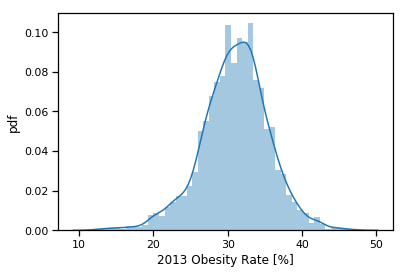

In [28]:
s = sns.distplot(master_df['PCT_OBESE_ADULTS13'].dropna())
dummy = s.set_xlabel('2013 Obesity Rate [%]')
dummy = s.set_ylabel('pdf')

Just as an aside, construct a QQ plot and run the Shapiro-Wilk test to test normality ($H_0$=normal distribution). We see that these two tests rule out normality for our obesity rate distribution.

Shapiro-Wilk normality test: W=0.99042, p=1.075e-13


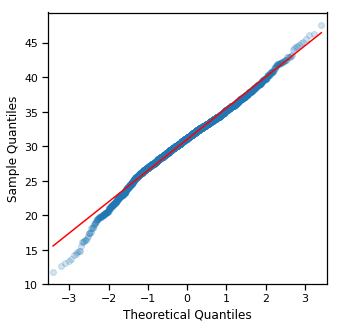

In [29]:
f, ax = plt.subplots(1,1,figsize=(5,5))
fig = gofplots.qqplot(master_df['PCT_OBESE_ADULTS13'], line='s', ax=ax, alpha=0.2, c='#1f77b4')

st, p = sp.stats.shapiro(master_df['PCT_OBESE_ADULTS13'])
print('Shapiro-Wilk normality test: W={:6.5f}, p={:6.3e}'.format(st, p))


Let's look at some other parameter distributions. There's a pretty remarkable spread in the population size of the county (also, look how log-symmetric-ish!). Adult diabetes rate is the percentage of the population with age > 20 and diabetes (e.g., types 1 and 2, and excluding gestational diabetes). Poverty rate is the percentage of the population with income below the poverty threshold, which varies by family size, age of the head of the household, etc. [For 2017](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-poverty-thresholds.html), it was approximately \\$12,500 for an individual and \\$25,100 for a family of 4. Low access to store is defined as the percentage of the population living > 1 mile (> 10 miles) from the nearest supermarket or grocery store in an urban (rural) area. The last distribution is strongly skewed to higher % of low access to store.

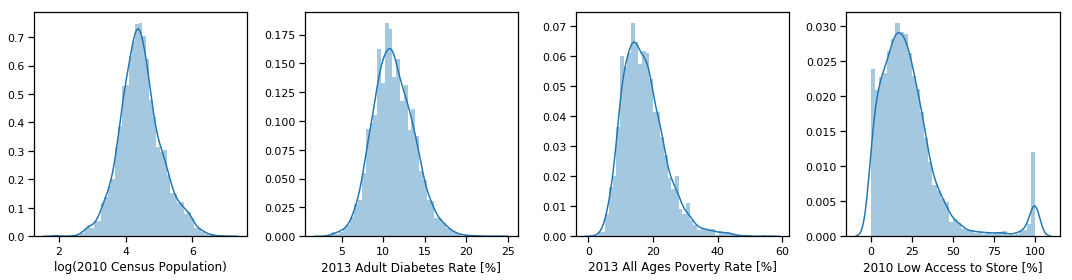

In [30]:
f, axes = plt.subplots(1,4,figsize=(15,4))
s = sns.distplot(np.log10(master_df['2010_CENSUS_POP'].dropna()), ax=axes[0])
s.set_xlabel('log(2010 Census Population)')
s = sns.distplot(master_df['PCT_DIABETES_ADULTS13'].dropna(), ax=axes[1])
s.set_xlabel('2013 Adult Diabetes Rate [%]')
s = sns.distplot(master_df['POVRATE13_ALL'].dropna(), ax=axes[2])
s.set_xlabel('2013 All Ages Poverty Rate [%]')
s = sns.distplot(master_df['PCT_LACCESS_POP10'].dropna(), ax=axes[3])
s.set_xlabel('2010 Low Access to Store [%]')
f.tight_layout()

In [31]:
min_pop_ind = master_df['2010_CENSUS_POP'].dropna().idxmin()
max_pop_ind = master_df['2010_CENSUS_POP'].dropna().idxmax()

print('According to the 2010 Census, county population ranges from ',
      master_df['COUNTY'][min_pop_ind], master_df['STATE'][min_pop_ind],':',
      int(min(master_df['2010_CENSUS_POP'].dropna())),
        'to', 
      master_df['COUNTY'][max_pop_ind], master_df['STATE'][max_pop_ind],':',
      int(max(master_df['2010_CENSUS_POP'].dropna())))

According to the 2010 Census, county population ranges from  Loving TX : 82 to Los Angeles CA : 9818605


Let's briefly examine the counties that have 100% of their population experiencing low access to store to understand the extreme values. After spot-checking a few counties along with a cross-reference Google map search, it seems that what appear to be regular grocery stores do exist near residential areas in these counties. Some guesses for why these counties are labeled to have low access to grocery stores for ~100% of their population are 1. these grocery stores do not meet the somewhat strict definition of "supermarket/large grocery store," e.g., more than \\$2 million in annual sales, 2. population data were not properly allocated to their 0.5 sq. km grids. The 100\% designation does appear to be correct for some of these counties (e.g., for Kiowa, CO, the nearest large grocery store, Safeway, is ~8 miles from town center) while for others, it is more ambiguous. Thus we will proceed without attempting to correct or remove these potential outliers, especially given their small numbers.

In [32]:
master_df[['STATE', 'COUNTY', 'METRO13', 'PCT_LACCESS_POP10']][master_df['PCT_LACCESS_POP10']>99.99].head()

,STATE,COUNTY,METRO13,PCT_LACCESS_POP10
72,AK,Denali,0,100.000001
81,AK,Lake and Peninsula,0,100.000000
95,AK,Yukon-Koyukuk,0,100.000000
271,CO,Hinsdale,0,99.999777
275,CO,Kiowa,0,100.000000


We can also examine the prevalence of adult obesity broken down separately for metro/nonmetro counties and counties with persistent poverty (poverty rate > 20% in the 1980, 1990, and 2000 censuses and the American Community Survey 5-year estimates for 2007-2011).

Text(0.5, 1.0, 'Metro/Persistent Poverty')

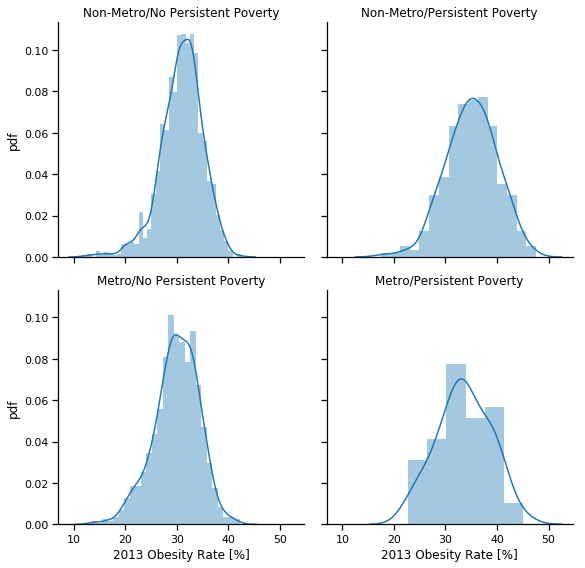

In [33]:
g = sns.FacetGrid(master_df, row='METRO13', col='PERPOV10', height=4)
g.map(sns.distplot, 'PCT_OBESE_ADULTS13').set_axis_labels("2013 Obesity Rate [%]", "pdf")
axes = g.axes.flatten()
axes[0].set_title("Non-Metro/No Persistent Poverty")
axes[1].set_title("Non-Metro/Persistent Poverty")
axes[2].set_title("Metro/No Persistent Poverty")
axes[3].set_title("Metro/Persistent Poverty")

Let's now move onto more explicitly examining relationships between obesity and the available parameters.

The positive trend between poverty and obesity rate is not too surprising if we are to believe that poverty is associated with poor food choices, which is in turn associated with poor health/obesity. There isn't a strong trend between the availability of farmers markets and obesity rate (the idea behind this was from anectdotal evidence that FMs tend to be more common among wealthy areas). There isn't a super obvious, strong correlation between the prevalence of FF restaurants and obesity rates. Based on studies such as [this](https://academic.oup.com/jcem/article/89/6/2590/2870291), we know that obesity disproportionately affects African-Americans and Mexican-Americans. This is confirmed by the data (for the African-American population at least, as separate Mexican-American data is not available).

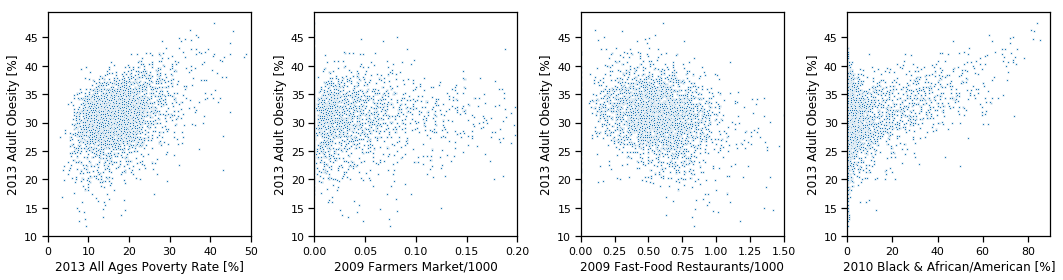

In [34]:
f, axes = plt.subplots(1,4,figsize=(15,4))
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='POVRATE13_ALL', data=master_df, ax=axes[0], s=5)
s.set_xlabel('2013 All Ages Poverty Rate [%]')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,50)
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='FMRKTPTH09', data=master_df, ax=axes[1], s=5)
s.set_xlabel('2009 Farmers Market/1000')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,0.2)
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='FFRPTH09', data=master_df, ax=axes[2], s=5)
s.set_xlabel('2009 Fast-Food Restaurants/1000')
s.set_xlim(0,1.5)
s.set_ylabel('2013 Adult Obesity [%]')
s = sns.scatterplot(y='PCT_OBESE_ADULTS13', x='PCT_NHBLACK10', data=master_df, ax=axes[3], s=5, legend='full')
s.set_xlabel('2010 Black & African/American [%]')
s.set_ylabel('2013 Adult Obesity [%]')
s.set_xlim(0,90)

f.tight_layout()

We can examine the same distributions broken up by race (above/below the [national average value according to the 2010 US. Census](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States)). It's interesting that obesity and diabetes rate distributions for counties with the fraction of the black/African-American population exceedin vs. below the national average (12.6%) show visible differences. This does not hold true for counties with fraction of the white population exceeding/below the national average (72.4%).

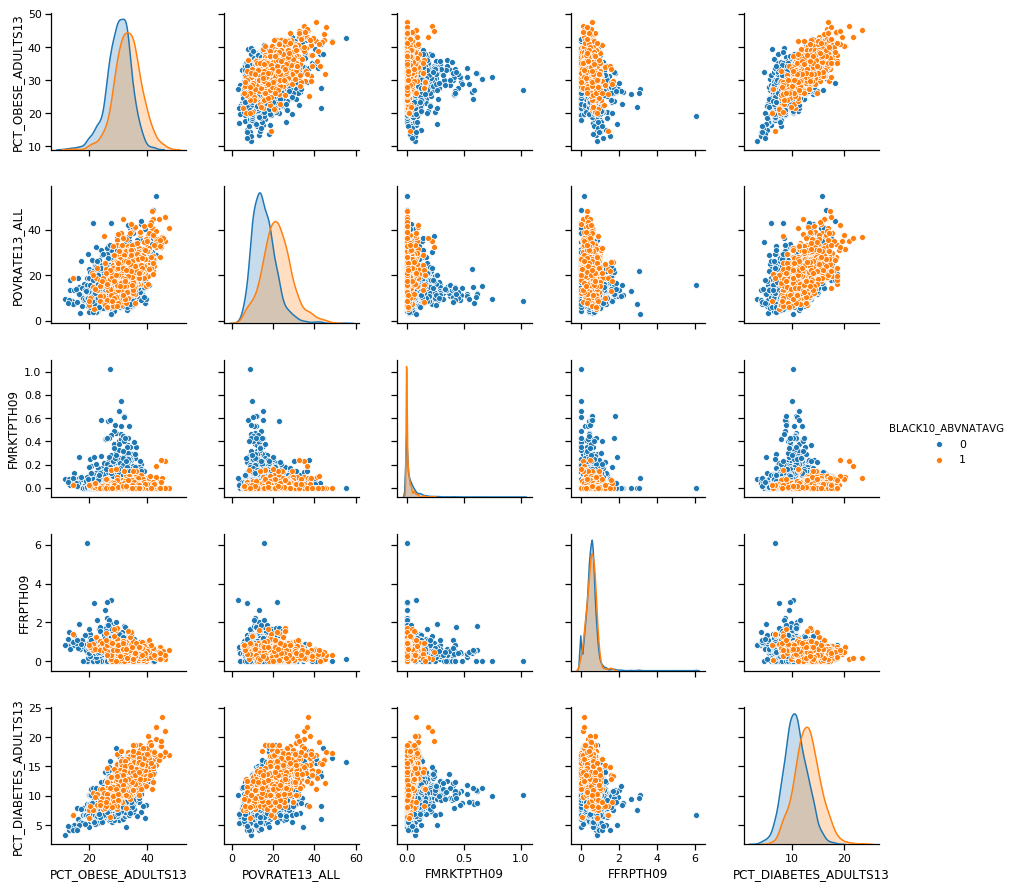

In [35]:
small_df = master_df[['PCT_OBESE_ADULTS13', 'POVRATE13_ALL', 'FMRKTPTH09', 'FFRPTH09', 'PCT_DIABETES_ADULTS13', 'PCT_NHBLACK10']].copy()
small_df['BLACK10_ABVNATAVG'] = small_df.apply(lambda x: int(x['PCT_NHBLACK10'] > 12.6), axis=1)

sns.pairplot(small_df, vars=['PCT_OBESE_ADULTS13', 'POVRATE13_ALL', 'FMRKTPTH09', 'FFRPTH09', 'PCT_DIABETES_ADULTS13'], hue='BLACK10_ABVNATAVG')

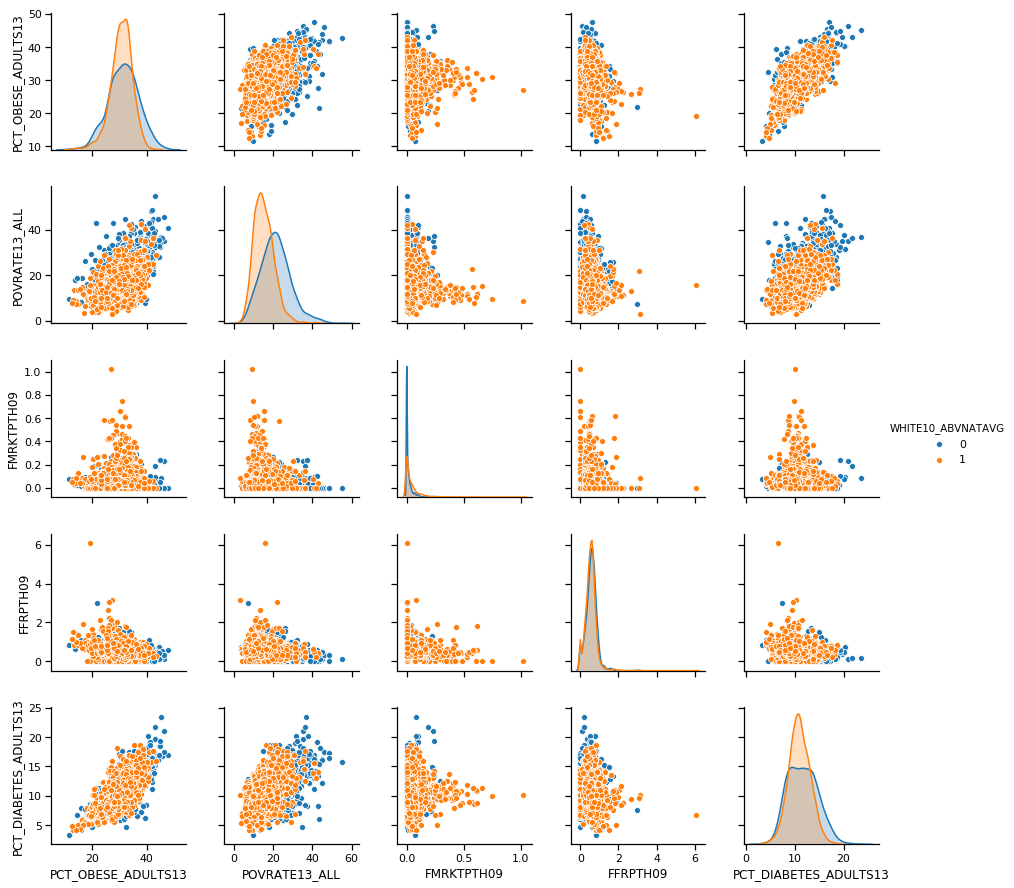

In [36]:
small_df = master_df[['PCT_OBESE_ADULTS13', 'POVRATE13_ALL', 'FMRKTPTH09', 'FFRPTH09', 'PCT_DIABETES_ADULTS13', 'PCT_NHWHITE10']].copy()
small_df['WHITE10_ABVNATAVG'] = small_df.apply(lambda x: int(x['PCT_NHWHITE10'] > 72.4), axis=1)

sns.pairplot(small_df, vars=['PCT_OBESE_ADULTS13', 'POVRATE13_ALL', 'FMRKTPTH09', 'FFRPTH09', 'PCT_DIABETES_ADULTS13'], hue='WHITE10_ABVNATAVG')

Next, although it may seem totally trivial, let's inspect poverty rate vs. median household income. As expected, there's a negative trend, but the exact form of this scatterplot is pretty interesting. The steep rise below the poverty rate of 10% implies that even in low-poverty areas, there's actually a large variability in the overall affluence of the population (ranging from ~40k to over 100k in median household income). Similarly, the long tail in the poverty rate beyond 10% implies that there are issues beyond the median income at play. At a fixed poverty rate, counties with higher % of white population seems to have higher median household incomes.

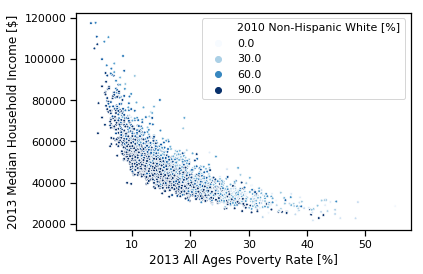

In [37]:
s = sns.scatterplot(x='POVRATE13_ALL', y='MEDHHINC13', hue='PCT_NHWHITE10', palette='Blues', hue_norm=(0,90), data=master_df, s=8)
legend = s.legend()
legend.texts[0].set_text("2010 Non-Hispanic White [%]")
dummy = s.set_xlabel('2013 All Ages Poverty Rate [%]')
dummy = s.set_ylabel('2013 Median Household Income [$]')


Just for fun, let's select a random subset of the counties and inspect the breakdown in race.

Text(0, 0.5, '2010 Population [%]')

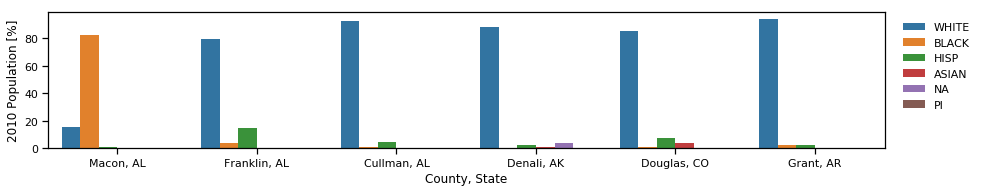

In [38]:
total_rows = np.shape(master_df)[1]
rand_ind = random.sample(range(1,287), 6)

plt.figure(figsize=(15,2.5))
race_df = master_df.iloc[rand_ind,:][['FIPS', 'STATE', 'COUNTY', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'PCT_HISP10', 'PCT_NHASIAN10', 'PCT_NHNA10', 'PCT_NHPI10']].copy()

race_df['COUNTY_STATE'] = race_df['COUNTY']+', '+race_df['STATE']
race_df = race_df.drop(columns=['FIPS', 'STATE', 'COUNTY'])

race_column_list = race_df.columns.drop('COUNTY_STATE')
race_df = race_df.rename(columns=lambda x: x.split('PCT_')[1].split('10')[0] if x in race_column_list else x)
race_column_list = race_df.columns.drop('COUNTY_STATE').drop('HISP')
race_df = race_df.rename(columns=lambda x: x.split('NH')[1] if x in race_column_list else x)

race_df = pd.melt(race_df, id_vars=['COUNTY_STATE'])
s = sns.barplot(x='COUNTY_STATE', y='value', hue='variable', data=race_df)
leg = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, frameon=False)

s.set_xlabel('County, State')
s.set_ylabel('2010 Population [%]') 

# Additional Prepwork

We have to do a few more things before we can throw the data at ML algorithms. 

We will rename the data to X following the general convention, then split into training and test sets. We'll remove 'PCT_DIABETES_ADULTS' columns because Type II diabetes is strongly associated with obesity (["People who are obese -- more than 20% over their ideal body weight for their height -- are at particularly high risk of developing type 2 diabetes and its related medical problems."](https://www.webmd.com/diabetes/guide/types-of-diabetes-mellitus#2)) and we are interested in obesity/diabetes as *predictions* of food environment factors.

In [39]:
X = master_df.drop(axis=1, labels=['FIPS', 'STATE', 'COUNTY', 'PCT_OBESE_ADULTS08', 'PCT_OBESE_ADULTS13', \
                                   'PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13'])
    
columns_to_log = ['MEDHHINC13', '2010_CENSUS_POP', 'POP_EST_2011', 'POP_EST_2012', 'POP_EST_2013']
for c in columns_to_log:
    X = convert2log(c, X)
y = master_df['PCT_OBESE_ADULTS13']

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=11)

The features that will be used to predict the obesity rate are listed below. Many of these features appear to be various representations/encodings of poverty/socioeconomic status.

In [41]:
X_train.describe()

for t in X_train.columns:
    try:
        variable_lookup(t)
    except:
        print(t)

PCT_NHWHITE10:  % White, 2010
PCT_NHBLACK10:  % Black, 2010
PCT_HISP10:  % Hispanic, 2010
PCT_NHASIAN10:  % Asian, 2010
PCT_NHNA10:  % American Indian or Alaska Native, 2010
PCT_NHPI10:  % Hawaiian or Pacific Islander, 2010
PCT_65OLDER10:  % Population 65 years or older, 2010
PCT_18YOUNGER10:  % Population under age 18, 2010
PERPOV10:  Persistent-poverty counties, 2010
PERCHLDPOV10:  Persistent-child-poverty counties, 2010
METRO13:  Metro/nonmetro counties, 2010
POPLOSS10:  Population-loss counties, 2010
FOODINSEC_10_12:  Household food insecurity (%, three-year average), 2010-12*
VLFOODSEC_10_12:  Household very low food security (%, three-year average), 2010-12*
FOODINSEC_CHILD_01_07:  Child food insecurity (% households, multiple-year average), 2001-07*
FOODINSEC_CHILD_03_11:  Child food insecurity (% households, multiple-year average), 2003-11*
REDEMP_SNAPS12:  SNAP redemptions/SNAP-authorized stores, 2012
PCT_SNAP12:  SNAP participants (% pop), 2012*
PC_SNAPBEN10:  SNAP benefits p

Next, standardize the features so they are all on the same order of magnitude. Apply the same transformation to the test set.

In [42]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_unscaled_test = X_test.copy()
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

## Feature Selection

We probably don't need all of the columns to predict the obesity rate, as there are columns that contain very little predictive power (i.e., noise) or are redundant with one another. 

For the first problem, we can try powerful techniques like PCA to try to reduce the dimensionality, but in the process, PCA generates new features that are not very easy to interpret. With this many features, we're not really suffering from computational issues, so we won't focus too much on paring down on the # of features.

For the second problem, let's see if we can gain some insight from two of the ML algorithms, Linear Regression and Random Forest Regression.

The coefficients fit from linear regression can be interpreted in an intuitive way. Features with large coefficients influence the prediction, or our target variable, more strongly. Unfortunately, here the features that are dominating with the biggest coefficients are the population data, because they are highly correlated amongst themselves. We will need to do some smart feature selection to deal with these collinearities.

Text(0, 0.5, 'Coefficients')

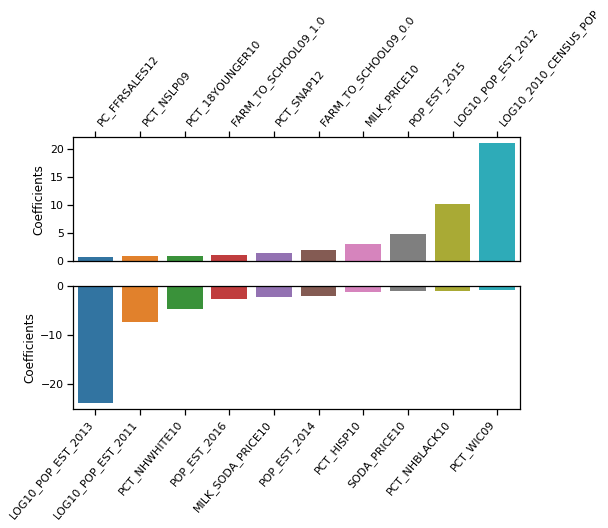

In [43]:
lr = LinearRegression()
lr.fit(X_scaled, y_train)

coef_neg = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[:10]
coef_pos = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[-10:]

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))
s = sns.barplot(x=coef_pos.index, y=coef_pos.values, ax=axes[0])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='left')
s.set_ylabel('Coefficients')

axes[0].xaxis.set_ticks_position('top')
s = sns.barplot(x=coef_neg.index, y=coef_neg.values, ax=axes[1])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='right')
s.set_ylabel('Coefficients')

Here's another way of inspecting feature importance with RF. This method doesn't appear to be strongly sensitive to collinearities in the data, as we do not see the population data appearing in the top 10.

/Users/jieunchoi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


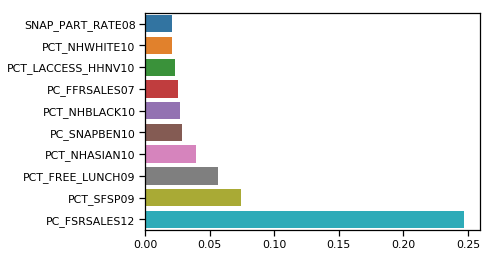

In [44]:
rf = RandomForestRegressor()
rf.fit(X_scaled, y_train)

feat_imp = rf.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-10:]

s = sns.barplot(x=feat_imp[feat_imp_ind], y=X_train.columns[feat_imp_ind])

## Dealing with Collinearity

We will remove feature columns with correlation coefficient > 0.6. We're using a handy code snippet taken directly from [here](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/). 

*Note: Multicollinearity actually has little effect on the performance of our algorithm of choice later on, GBR. However, dealing with collinearity does help us understand and identify the important features in this section.*

In [45]:
corr_matrix = X_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [46]:
X_scaled = X_scaled.drop(columns=to_drop, axis=1)
X_test = X_test.drop(columns=to_drop, axis=1) #apply to the test set also so we don't forget later!
X_unscaled_test.drop(columns=to_drop, axis=1)
X_scaled.head()

,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,...,FMRKTPTH09,POP_EST_2014,SNAP_OAPP09_0.0,SNAP_OAPP09_0.5,SNAP_CAP09_0,SNAP_BBCE09_0,SNAP_REPORTSIMPLE09_0,FARM_TO_SCHOOL09_0.0,FARM_TO_SCHOOL13_0.0,LOG10_2010_CENSUS_POP
1573,0.365275,-0.159568,-0.359978,-0.218055,1.322681,-0.643726,0.620716,0.029835,1.0,1.0,...,-0.262950,-0.220537,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.343675
760,-0.006229,0.095592,0.848879,1.024779,-0.199263,-0.115069,-0.624709,0.257894,0.0,0.0,...,-0.126488,2.590838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.048824
1902,-0.524819,1.344777,1.001154,2.084840,-0.043463,0.300918,-0.841065,1.105480,0.0,0.0,...,-0.003694,3.039245,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.094124
2131,-1.594368,-0.171277,0.330943,0.144181,97.223519,-0.520171,-0.518391,1.274891,1.0,1.0,...,-0.262950,-0.070359,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-0.074086
283,-0.108910,-0.140918,1.633293,0.360210,0.729245,2.221486,-0.133125,0.049276,0.0,0.0,...,0.195489,2.227237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984518


Now redo the checks from above. Again, important features for both of these methods appear to be measures of poverty (PCT_SNAP: 2012 SNAP participants (% pop), WICSPTH: 2008 WIC-authorized stores/1000 pop).

Text(0, 0.5, 'Coefficients')

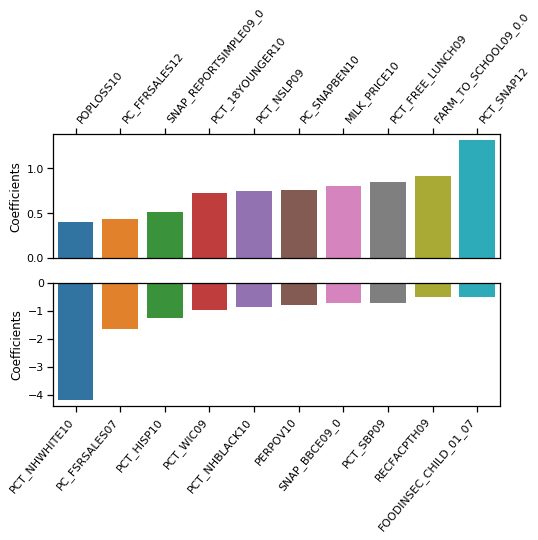

In [47]:
lr = LinearRegression()
lr.fit(X_scaled, y_train)

coef_neg = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[:10]
coef_pos = pd.Series(lr.coef_.reshape(-1,), index=X_scaled.columns).sort_values()[-10:]

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 5))
s = sns.barplot(x=coef_pos.index, y=coef_pos.values, ax=axes[0])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='left')
s.set_ylabel('Coefficients')

axes[0].xaxis.set_ticks_position('top')
s = sns.barplot(x=coef_neg.index, y=coef_neg.values, ax=axes[1])
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=50, ha='right')
s.set_ylabel('Coefficients')

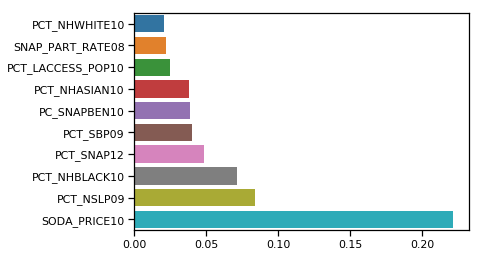

In [48]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_scaled, y_train)

feat_imp = rf.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-10:]

s = sns.barplot(x=feat_imp[feat_imp_ind], y=X_train.columns[feat_imp_ind])

# Training ML algorithms

## Establishing a Baseline

Before we proceed, let's first establish a baseline performance to compare with subsequent results. A very simple baseline guess is the median of the target values. We will use two metrics, MAE (mean absolute error, so we want to minimize) and adjusted $R^2$ (MSE/variance in $y$ weighed by the numbers of observations and features, so we want to maximize to 1). 

Unlike $R^2$, adjusted $R^2$ will not arbitrary increase with an increasing number of terms if the added complexity in the model does not actually improve the prediction.

Another popular choice is RMSE (root mean square error, i.e., standard deviation) because it's easily and smoothly differentiable, but the squaring makes it pretty sensitive to outliers. 



In [49]:
kf = model_selection.KFold(n_splits=5)

mae_list = []
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]
    y_simple_guess = np.median(y_train_kf)
    mae_list.append(np.sum(abs(y_simple_guess-y_val_kf)/len(y_val_kf)))

print("MAE: {:3.2f}".format(np.mean(mae_list)))

MAE: 3.47


We will test the following ML algorithms.

- Linear Regression (without regularization, L1/L2 regularizations)
- K Nearest Neighbors
- Gradient Boosting (_we will use the sklearn version, though apparently it is not as fast as e.g., xgboost_)
- Random Forest
- Suppert Vector Machine

In [50]:
#choosing default parameters. explicitly specified  n_estimators and gamma for RF and SVM to ward off warning messages.
model_list = {'LR':LinearRegression(), 'LASSO':Lasso(), 'RIDGE':Ridge(), 'KNN':KNeighborsRegressor(), \
              'GBR':GradientBoostingRegressor(), 'RF':RandomForestRegressor(n_estimators=100), 'SVM':SVR(gamma='scale')}

In [51]:
for m in model_list.keys():
    
    kf = model_selection.KFold(n_splits=5)
    mae_list = []
    adjusted_r2_list = []
    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        clf = model_list[m]
        clf.fit(X_train_kf, y_train_kf)
        y_pred = clf.predict(X_val_kf)
        
        mae_list.append(np.sum(abs(y_pred-y_val_kf)/len(y_val_kf)))
        adjusted_r2_list.append(adjusted_r2(y_val_kf, y_pred, np.shape(X_train_kf)[0], np.shape(X_train_kf)[1]))
    
    print("{:4}".format(m)+" ----- ", "MAE: {:3.2f}".format(np.mean(mae_list)), \
          " --  R2_adj: {:3.2f}".format(np.mean(adjusted_r2_list)))
    

LR   -----  MAE: 2.21  --  R2_adj: 0.59
LASSO -----  MAE: 2.79  --  R2_adj: 0.34
RIDGE -----  MAE: 2.21  --  R2_adj: 0.59
KNN  -----  MAE: 2.34  --  R2_adj: 0.53
GBR  -----  MAE: 1.99  --  R2_adj: 0.67
RF   -----  MAE: 2.04  --  R2_adj: 0.65
SVM  -----  MAE: 2.31  --  R2_adj: 0.53


## Hyperparameter Tuning

RF and GBR both seem promising. Let's try tuning the relevant hyperparameters for GBR to see if we can improve its performances.

Rather than searching the hyperparameter space via grid search (brute-force) or randomized search (slight improvement over grid search), we will turn to a Bayesian optimization technique (tree parzen estimator) via [hyperopt](https://github.com/hyperopt/hyperopt).

First define an objective function that returns a loss to be minimized. We will use a cross validation score so that we don't have to split the data further into training & validation sets.

In [52]:
def objective(hparams):
    
    gbr = GradientBoostingRegressor(**hparams)
    cv_score = model_selection.cross_val_score(gbr, X_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    loss = -np.mean(cv_score)
    
    #progress bar
    pbar.update()
    
    return {'loss': loss, 'hparams': hparams, 'status': STATUS_OK}    

Define the characteristics of the hyperparameter space over which we will conduct our search. We will choose uniform distributions for simplicity.

In [53]:
domain = {
    "learning_rate": hp.loguniform("learning_rate", -6, 0),\
    "n_estimators": scope.int(hp.quniform("n_estimators",20,150,2)),\
    "subsample": hp.uniform("subsample", 0.1,1.0),\
    "min_samples_split": scope.int(hp.quniform('min_samples_split', 2,30,1)),\
    "min_samples_leaf": scope.int(hp.quniform('min_samples_leaf', 1,5,1)),\
    "max_depth": scope.int(hp.quniform('max_depth', 1,5,1)),\
    "max_features": hp.uniform('max_features',0.01,1.0)
}

Store the training information.

In [54]:
bayes_trials = Trials()

In [55]:
MAX_EVALS = 1000
pbar = tqdm_notebook(total=MAX_EVALS, desc='Hyperopt')

best = fmin(fn=objective, space=domain, algo=tpe.suggest, \
            max_evals=MAX_EVALS, trials=bayes_trials)
pbar.close()

Hyperopt returns the parameters as floats, so convert the relevant ones back to integer data types.

In [56]:
#just a backup copy
best_bu = best.copy()

hyperparam_list = list(best.keys())
hyperparam_list.pop(hyperparam_list.index("learning_rate"))
hyperparam_list.pop(hyperparam_list.index("subsample"))
hyperparam_list.pop(hyperparam_list.index("max_features"))

for key in hyperparam_list:
    best[key] = int(best[key])

In [57]:
print(best)

{'learning_rate': 0.0691179795613075, 'max_depth': 5, 'max_features': 0.16001471819583712, 'min_samples_leaf': 4, 'min_samples_split': 18, 'n_estimators': 142, 'subsample': 0.8337933814060846}


Text(0, 0.5, 'loss')

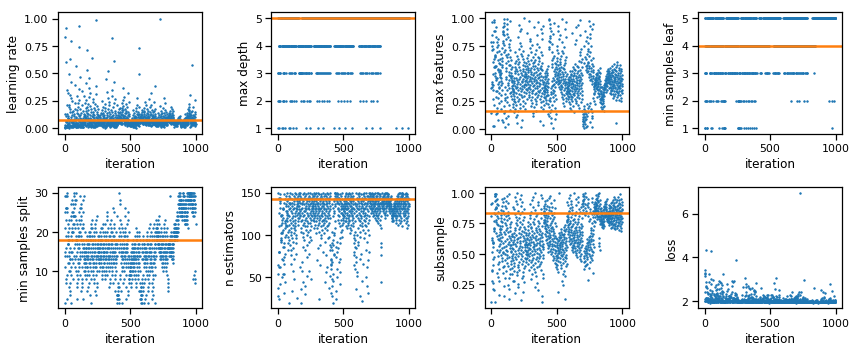

In [58]:
plt.figure(1, figsize=(12,5))
for i_k, k in enumerate(bayes_trials.vals.keys()):
    ax = plt.subplot('24'+str(i_k+1))
    ax.scatter(range(len(bayes_trials.vals[k])), bayes_trials.vals[k], label=k, s=2)
    ax.set_ylabel(' '.join(k.split('_')))
    ax.set_xlabel('iteration')
    ax.axhline(best[k], color='C1', linewidth=2.5)
    plt.tight_layout()

ax = plt.subplot('24'+str(7+1))
ax.scatter(range(len(bayes_trials.losses())), bayes_trials.losses(), s=2)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')


## Learning Curve
Before we move on to deploying the best model, let's construct a learning curve to examinie the bias-variance trade-off.

In [59]:
dummy_best = best.copy()
train_size, train_scores, test_scores = model_selection.learning_curve(GradientBoostingRegressor(**best), \
                                                            X_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=5, scoring='neg_mean_absolute_error')

train_scores = np.abs(train_scores)
test_scores = np.abs(test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

As expected, the test (CV) error is larger than the training error (CV error was computed on previously unseen data). There appears to be some overfitting (difference in MAE of ~1, or error in the obesity rate of 1%), meaning the current model has high variance. Getting more data is not really an option, since we are limited to the # of counties in the U.S. We could try increasing regularization or decreasing the number of features (which, recall, has been already reduced to deal with collinearity). Let's move on to examining the validation curves below and see how individual parameters of our model influence this bias-variance trade off.

(0, 3)

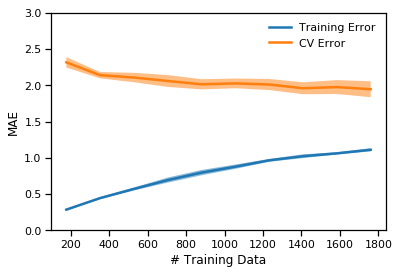

In [60]:
plt.plot(train_size, train_scores_mean, linewidth=2.5, label='Training Error')
plt.fill_between(train_size, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.5)

plt.plot(train_size, test_scores_mean, linewidth=2.5, label='CV Error')
plt.fill_between(train_size, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.5)

plt.xlabel('# Training Data')
plt.ylabel('MAE')

leg = plt.legend(loc=1, frameon=False)
plt.ylim(0, 3)

## Validation Curves
We will also plot the validation curve for a few hyperparameters.

In [61]:
def plot_validation_curve(p, p_arr, p_label):

    train_scores, test_scores = model_selection.validation_curve(GradientBoostingRegressor(**best), \
                                                            X_scaled, y_train, p, p_arr,
                                                            cv=5, scoring='neg_mean_absolute_error')

    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(p_arr, train_scores_mean, linewidth=2.5, label='Training Error')
    plt.fill_between(p_arr, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.5)
    
    plt.plot(p_arr, test_scores_mean, linewidth=2.5, label='CV Error')
    plt.fill_between(p_arr, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.5)
    
    plt.xlabel(p_label)
    plt.ylabel('MAE')
    
    leg = plt.legend(loc=1, frameon=False)

First, n_estimators is the number of boosting stages, or the # of decision trees. We see that the two errors quickly diverge beyond ~50, and CV errors asymptotes while training error continues to decrease: as we increase the number of estimators, the training set becomes increasingly overfit. 

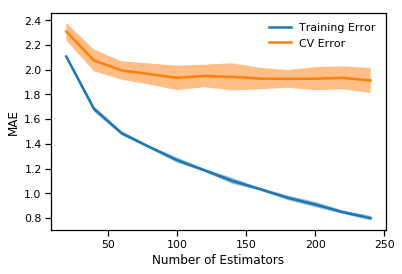

In [62]:
plot_validation_curve('n_estimators', np.arange(20, 250, 20), 'Number of Estimators')

learning_rate controls the weight of each tree. A smaller learning_rate, or shrinkage, helps to fight against overfitting. From this validation curve, a good learning rate seems to be around 0.01.

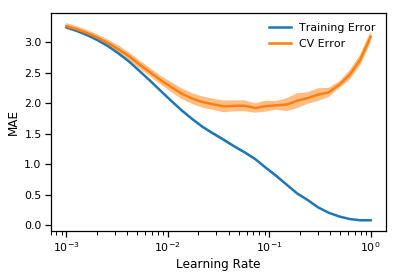

In [63]:
plot_validation_curve('learning_rate', np.logspace(-3, 0, 30), 'Learning Rate')
plt.xscale('log')

The deeper the individual tree goes, the more it will overfit. 

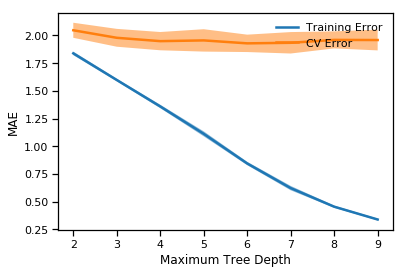

In [64]:
plot_validation_curve('max_depth', np.arange(2,10), 'Maximum Tree Depth')

subsample describes the fraction of the samples used to fit each tree. subsample < 1 = (mini-batch) Stochastic Gradient Boosting, which helps to fight overfitting, though if this value gets too small, the model severely underfits.

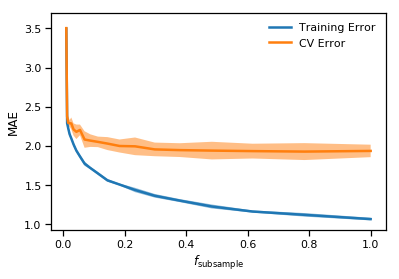

In [65]:
plot_validation_curve("subsample", np.logspace(-2, 0, 20), r'$f_{\rm subsample}$')

Note that all CV errors plateau to ~2% regardless of the choice of parameters, # samples, etc.

# Predict the Obesity Rates

Train on the full train data set then check the MAE and the adjusted $R^2$ scores on the test set.

In [66]:
gbr_tuned = GradientBoostingRegressor(**best)
gbr_tuned.fit(X_scaled, y_train)
y_pred = gbr_tuned.predict(X_test)
print("{:4}".format('GBR')+" ----- ", "MAE: {:3.2f}".format(metrics.mean_absolute_error(y_test, y_pred)), \
      " --  R2_adj: {:3.2f}".format(adjusted_r2(y_test, y_pred, np.shape(X_test)[0], np.shape(X_test)[1])))

GBR  -----  MAE: 1.93  --  R2_adj: 0.70


In terms of mean absolute error, this is a 3% improvement over the model prior to hyperparameter tuning and nearly 80% improvement over the naive baseline model (median)!

# Interpreting the Results

### Residuals (still needs more work!)
Let's examine the residual as a function of the true obesity rate. There is a relatively strong systematic trend in the residuals, and a few outliers at the low end of obesity rates.

Text(0, 0.5, '(True - Predicted)/True [%]')

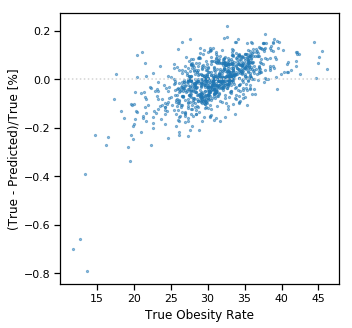

In [67]:
plt.figure(figsize=(5,5))
plt.axhline(0, linestyle=':', color='LightGray')
plt.scatter(y_test, (y_test-y_pred)/y_test, alpha=0.5, s=5)

plt.xlabel("True Obesity Rate")
plt.ylabel("(True - Predicted)/True [%]")

Let's identify predictions that are off by more than 20% in residuals. Where are these outliers relative to the rest of the data in various data spaces?

In [68]:
poor_pred = np.where(abs(y_test-y_pred)/y_test > 0.20)
poor_pred_index = y_test.index[poor_pred]
poor_pred_summary_info = master_df.loc[poor_pred_index,:].describe()

good_pred = np.where(abs(y_test-y_pred)/y_test <= 0.20)
good_pred_index = y_test.index[good_pred]
good_pred_summary_info = master_df.loc[good_pred_index,:].describe()

pd.set_option('max_columns', 1000)
master_df.loc[poor_pred_index,:].sort_values('FIPS')

,FIPS,STATE,COUNTY,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,PERPOV10,PERCHLDPOV10,METRO13,POPLOSS10,FOODINSEC_10_12,VLFOODSEC_10_12,FOODINSEC_CHILD_01_07,FOODINSEC_CHILD_03_11,REDEMP_SNAPS12,PCT_SNAP12,PC_SNAPBEN10,SNAP_PART_RATE08,SNAP_PART_RATE13,PCT_NSLP09,PCT_FREE_LUNCH09,PCT_REDUCED_LUNCH09,PCT_SBP09,PCT_SFSP09,PCT_WIC09,PCT_CACFP09,PCT_LACCESS_POP10,PCT_LACCESS_LOWI10,PCT_LACCESS_HHNV10,PCT_LACCESS_CHILD10,PCT_LACCESS_SENIORS10,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,RECFACPTH09,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,FFRPTH09,PC_FFRSALES07,PC_FFRSALES12,PC_FSRSALES07,PC_FSRSALES12,GROCPTH09,SUPERCPTH09,CONVSPTH09,SPECSPTH09,SNAPSPTH12,WICSPTH08,WICSPTH12,PCT_LOCLFARM07,PCT_LOCLFARM12,PCT_LOCLSALE12,PC_DIRSALES07,PC_DIRSALES12,FMRKTPTH09,2010_CENSUS_POP,POP_EST_2011,POP_EST_2012,POP_EST_2013,POP_EST_2014,POP_EST_2015,POP_EST_2016,POVRATE13_ALL,MEDHHINC13,POVRATE13_CHILD,SNAP_OAPP09_0.0,SNAP_OAPP09_0.5,SNAP_OAPP09_1.0,SNAP_CAP09_0,SNAP_CAP09_1,SNAP_BBCE09_0,SNAP_BBCE09_1,SNAP_REPORTSIMPLE09_0,SNAP_REPORTSIMPLE09_1,FARM_TO_SCHOOL09_0.0,FARM_TO_SCHOOL09_1.0,FARM_TO_SCHOOL13_0.0,FARM_TO_SCHOOL13_1.0
235,6099,CA,Stanislaus,46.733715,2.539591,41.919864,4.803549,0.557874,0.586254,10.658116,28.604751,0,0,1,0.0,15.6,5.7,10.4,10.8,359674.427430,10.474326,20.092052,48,66.446,8.590152,51.235462,10.297426,3.172785,0.257240,3.893239,0.886968,13.409983,4.823791,1.121852,3.926595,1.327037,8.1,9.7,30.2,32.6,0.078196,1.032918,1.089488,0.877073,0.613838,761.447125,642.487457,755.587505,750.318646,0.250227,0.005865,0.285415,0.068421,0.850862,0.199034,0.243423,5.882353,5.310162,0.205733,8.329493,8.779978,0.009797,514453.0,518073.0,521360.0,524744.0,529754.0,535385.0,541560.0,21.8,47808.0,30.5,0,1,0,1,0,0,1,1,0,0,1,0,1
247,8007,CO,Archuleta,78.169480,0.273088,17.775571,0.653757,1.373717,0.033102,17.510758,19.927176,0,0,0,0.0,14.1,5.8,8.0,8.8,194814.287767,9.512323,10.875262,52,80.983,7.778858,37.771918,12.854318,2.132226,0.254819,2.147968,0.686204,22.685100,7.740627,1.441499,4.549467,3.823740,5.4,5.9,15.7,16.5,0.164352,0.940068,1.079599,0.805544,0.903936,747.095794,617.951624,900.316210,877.923282,0.328704,0.000000,0.575232,0.164352,0.711130,0.160038,0.082850,9.150327,11.827957,0.767990,16.147447,9.823345,0.080451,12084.0,12011.0,12113.0,12194.0,12229.0,12384.0,12854.0,15.1,44417.0,26.1,1,0,0,1,0,1,0,0,1,1,0,1,0
250,8013,CO,Boulder,79.350708,0.768925,13.333469,4.072418,0.360190,0.051941,10.021829,21.303812,0,0,1,0.0,14.1,5.8,8.0,8.8,257452.004021,9.512323,6.978039,52,80.983,7.778858,21.187371,3.813773,2.132226,0.254819,2.147968,0.686204,15.569675,2.842225,0.566456,3.927944,1.552966,3.5,4.1,13.2,13.4,0.180770,0.746075,0.995180,0.693543,0.818582,747.095794,617.951624,900.316210,877.923282,0.167127,0.020465,0.269450,0.085269,0.355640,0.073223,0.062230,14.075067,14.736842,5.173686,2.487579,5.737233,0.032951,294567.0,300597.0,305350.0,310287.0,313204.0,318738.0,322226.0,13.5,71405.0,12.8,1,0,0,1,0,1,0,0,1,1,0,0,1
263,8037,CO,Eagle,67.254823,0.465544,30.057283,0.990478,0.256720,0.028737,5.628676,24.522482,0,0,0,0.0,14.1,5.8,8.0,8.8,215199.977326,9.512323,3.478808,52,80.983,7.778858,29.159640,7.349635,2.132226,0.254819,2.147968,0.686204,15.267278,4.227530,0.938510,3.836535,0.825025,3.0,3.3,12.9,11.8,0.152343,0.746075,0.995180,0.693543,0.837888,747.095794,617.951624,900.316210,877.923282,0.266601,0.038086,0.342772,0.095215,0.300407,0.134566,0.134942,7.894737,13.333333,1.423532,1.003956,2.173453,0.074553,52197.0,51751.0,51942.0,52379.0,52815.0,53346.0,53989.0,9.5,78517.0,13.6,1,0,0,1,0,1,0,0,1,1,0,1,0
270,8051,CO,Gunnison,89.128165,0.293657,8.189768,0.613417,0.398068,0.026103,8.816236,18.141477,0,0,0,0.0,14.1,5.8,8.0,8.8,133450.687805,9.512323,6.563778,52,80.983,7.778858,14.301430,5.115512,2.132226,0.254819,2.147968,0.686204,12.042656,2.137880,1.157127,1.926900,2.005861,3.6,4.6,14.9,14.8,0.325606,0.940068,1.079599,0.805544,0.846575,747.095794,

Text(0, 0.5, 'Obesity Rate [%]')

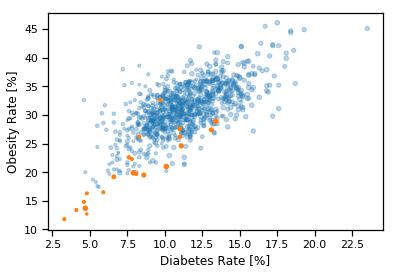

In [69]:
plt.scatter(master_df.loc[good_pred_index,:]['PCT_DIABETES_ADULTS13'], \
            master_df.loc[good_pred_index,:]['PCT_OBESE_ADULTS13'], \
            s=master_df.loc[good_pred_index,:]['PCT_SNAP12'], alpha=0.3)
plt.scatter(master_df.loc[poor_pred_index,:]['PCT_DIABETES_ADULTS13'], \
            master_df.loc[poor_pred_index,:]['PCT_OBESE_ADULTS13'], \
            s=master_df.loc[poor_pred_index,:]['PCT_SNAP12'])
plt.xlabel('Diabetes Rate [%]')
plt.ylabel('Obesity Rate [%]')

Text(0, 0.5, 'Obesity Rate [%]')

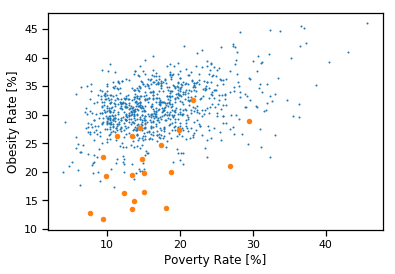

In [70]:
plt.scatter(master_df.loc[good_pred_index,:]['POVRATE13_ALL'], \
            master_df.loc[good_pred_index,:]['PCT_OBESE_ADULTS13'], s=1)
plt.scatter(master_df.loc[poor_pred_index,:]['POVRATE13_ALL'], \
            master_df.loc[poor_pred_index,:]['PCT_OBESE_ADULTS13'], s=20)
plt.xlabel('Poverty Rate [%]')
plt.ylabel('Obesity Rate [%]')

Any differences in the overall statistics?

In [71]:
good_pred_summary_info['PCT_DIABETES_ADULTS13']

count    922.000000
mean      11.254447
std        2.458544
min        4.600000
25%        9.500000
50%       11.100000
75%       12.800000
max       23.500000
Name: PCT_DIABETES_ADULTS13, dtype: float64

In [72]:
poor_pred_summary_info['PCT_DIABETES_ADULTS13']

count    21.000000
mean      7.928571
std       2.976935
min       3.300000
25%       4.800000
50%       7.900000
75%      10.100000
max      13.400000
Name: PCT_DIABETES_ADULTS13, dtype: float64

### Feature Importance
Let's examine which features played a crucial role in predicting the obesity rates. In scikit-learn, the feature importance of a single predictor variable is defined by combining the following: the fraction of the samples split according to the said variable&mdash;a measure of its "sphere of influence," if you will&mdash;and the decrease in Gini impurity resulting from the said split. Feature importances are computed for a given decision tree, and these values are averaged over the ensemble of trees to provide the final list of feature importances that we will examine here. 

The key predictive features are an interesting mix of socioeconomic status, and more surprising factors such as soda prices and the availability of recreational facilities.

WICSPTH08:  WIC-authorized stores/1,000 pop, 2008
PCT_18YOUNGER10:  % Population under age 18, 2010
PCT_LACCESS_CHILD10:  Children, low access to store (%), 2010
PCT_LACCESS_POP10:  Population, low access to store (%), 2010
PCT_NHASIAN10:  % Asian, 2010
PCT_NSLP09:  National School Lunch Program participants (% pop), 2009*
RECFACPTH09:  Recreation & fitness facilities/1,000 pop, 2009
PC_SNAPBEN10:  SNAP benefits per capita, 2010
PCT_SNAP12:  SNAP participants (% pop), 2012*
SNAP_PART_RATE13:  SNAP participants (% eligible pop), 2013*
PCT_NHBLACK10:  % Black, 2010
SODA_PRICE10:  Price of sodas/national average, 2010**


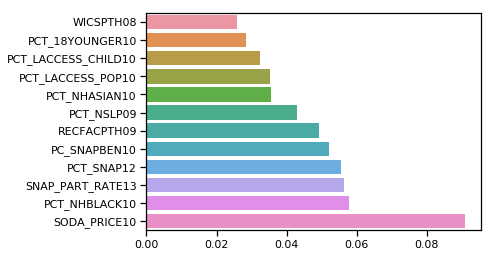

In [73]:
tuned_feat_imp = gbr_tuned.feature_importances_
tuned_feat_imp_ind = np.argsort(tuned_feat_imp)[-12:]

s = sns.barplot(x=tuned_feat_imp[tuned_feat_imp_ind], y=X_unscaled_test.columns[tuned_feat_imp_ind])

for feat in X_unscaled_test.columns[tuned_feat_imp_ind]:
    try:
        variable_lookup(feat)
    except:
        pass

Examine the relationship between our target variable (obesity rate) and these important features. Here, samples with residuals > 20% are denoted by the large symbols in addition to the colors.

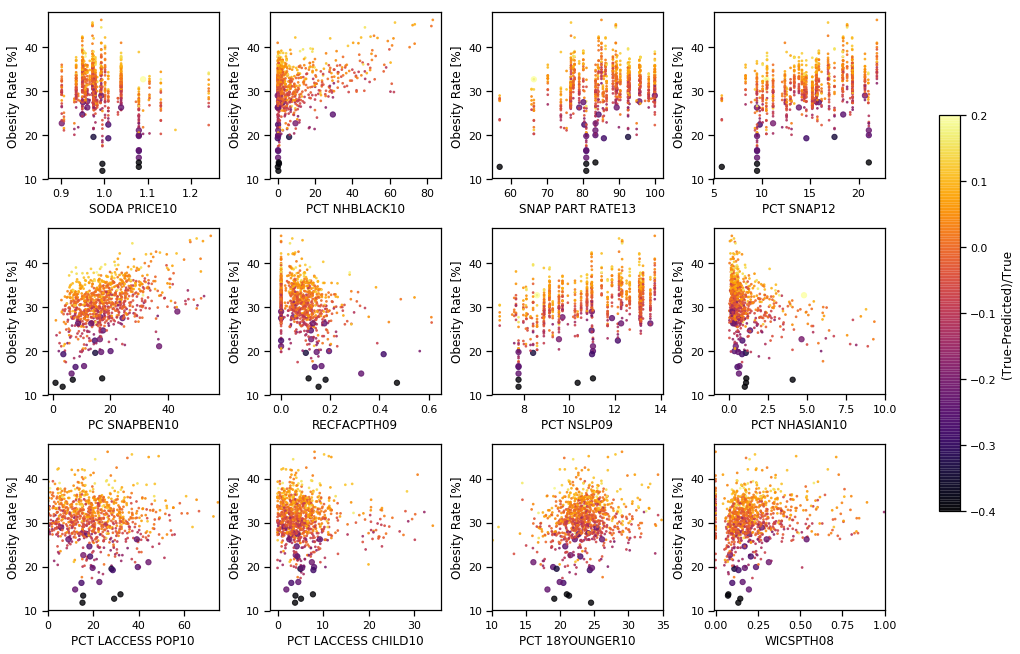

In [81]:
residual = (y_test-y_pred)/y_test

f, axes = plt.subplots(3,4, figsize=(15,11))
for i_a, ax in enumerate(axes.flatten()):
    s = (abs(y_test-y_pred)/y_test > 0.20)*25 + 3
    t = ax.scatter(X_unscaled_test[X_unscaled_test.columns[tuned_feat_imp_ind][::-1][i_a]], y_test, s=s, c=residual, vmin=-0.4, vmax=0.2, cmap='inferno', alpha=0.8)
    ax.set_xlabel(' '.join(X_unscaled_test.columns[tuned_feat_imp_ind][::-1][i_a].split('_')))
    ax.set_ylabel('Obesity Rate [%]')
    if (i_a == 7):
        ax.set_xlim(-1, 10)
    if (i_a == 8):
        ax.set_xlim(-0.01, 75)
    if (i_a == 10):
        ax.set_xlim(10, 35)
    if i_a == 11:
        ax.set_xlim(-0.01, 1)

cbar_ax = f.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = f.colorbar(t, cax=cbar_ax)        
cbar.set_label('(True-Predicted)/True')

plt.subplots_adjust(wspace=0.3, hspace=0.3)
